# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Determinación-de-los-parámetros-de-los-polarizadores-lineales" data-toc-modified-id="Determinación-de-los-parámetros-de-los-polarizadores-lineales-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Determinación de los parámetros de los polarizadores lineales</a></div><div class="lev2 toc-item"><a href="#Cargar-la-intensidad-con-P1-y-P4" data-toc-modified-id="Cargar-la-intensidad-con-P1-y-P4-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Cargar la intensidad con P1 y P4</a></div><div class="lev2 toc-item"><a href="#Resultados" data-toc-modified-id="Resultados-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Resultados</a></div>

# Determinación de los parámetros de los polarizadores lineales

**Autor**: Luis Miguel Sanchez Brea

**Fecha**:   21/03/2018

**Objetivo**: Ecograb project, polariscope callibration

**Configuración**:

1. Diodo láser de Roithner .... de longitud de onda $\lambda$=850 nm (corriente = 314 mA).
1. Lente colimadora de Thorlabs DG10-600-B.
1. Difusor.
1. Lámina retardadora $\lambda/4$ ... de Throlabs para hacer el haz de luz circular.
1. Polarizador 1
1. Polarizador 4

**Procedimiento**:

Una vez conocido el angulo de P1, se pone horizontal a la superficie. 

1. Se gira el polarizador P4 una vuelta.


**Resultado**

1. Posición del ángulo de P4 respecto a P1
1. Parámetros de P1 a partir del valor máximo y mínimo de intensidad


El ángulo de P1 donde haya máxima intensidad es aquel alineado con el suelo.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import time
import pprint

np.set_printoptions(precision=4)
sp.set_printoptions(precision=4)

from phyton_optics import degrees 

from scipy import optimize
from polarimeter.utils import plot_experiment_residuals_1D
from polarimeter.polarimeter import (get_polarimeter_parameters, intensity, 
                                    polarimeter_matrices, get_light_parameters)

from phyton_optics.polarization_stokes import polarizer_linear, rotate_mueller

from scipy.io import loadmat

## Cargar la intensidad con P1 y P4

El máximo de intensidad alinea el eje P4 con P1.

El motor 1 esta en 0 grados, por lo que el eje del polarizador esta a 6.6962 º

Se mueve el motor 4.

La posición de máximo los dos polarizadores lineales están alineados

In [3]:
data_2=np.load('step4_parametros_P4_polarizer_2018-03-21.npy')
#angles_2 esta en 0-360 hay que pasar de 0 a 2pi
angles_2=data_2[:,0]*degrees
intensities_2=data_2[:,1]

plt.figure(figsize=(14,4))
plt.plot(angles_2/degrees,intensities_2,'k')
plt.ylim(0,intensities_2.max()*1.1)
plt.xlim(0,360)

(0, 360)

## Fitting data to sine

Fit examples with sinusoidal functions

In [4]:
#Fitting parameters 
# Fit the first set
sin_func = lambda par, x: par[0]+par[1]*np.cos(np.pi/par[2]*(x-par[3]))**2 # Target function
errfunc = lambda par, x, y: sin_func(par, x) - y # Distance to the target function

In [9]:
par0 = [0,2.5, sp.pi, 0.] # Initial guess for the parameters
par1, success = optimize.leastsq(errfunc, par0[:], args=(angles_2, intensities_2))
if par1[3]<0:
    par1[3]=par1[3]+sp.pi

print (par1[0], par1[1], par1[2]/degrees, par1[3]/degrees)

I_fitting=sin_func(par1, angles_2)
residuals=intensities_2-I_fitting

plot_experiment_residuals_1D(angles_2, intensities_2, I_fitting,  title='')

0.0512939295162 1.29433070742 179.916946646 179.308300991


## Calibration parameters

In [10]:
Imin=par1[0]
Imax=par1[0]+par1[1]
I0 = 3.45107138
angle4_max=par1[3]-sp.pi

if Imin>Imax:
    Imin,Imax=Imax,Imin

print("I0        = {:4.4} V".format(I0))
print("Imin      = {:4.4} V".format(Imin))
print("Imax      = {:4.4} V".format(Imax))
print("angle_max = {:4.5} º".format(angle4_max/degrees))

p0=((Imax+sp.sqrt(Imax**2-Imin**2))/I0)**(0.25)
p1=sp.sqrt(Imin/sp.sqrt(I0*(Imax+sp.sqrt(Imax**2-Imin**2))))

if p0>p1:
    p0,p1=p1,p0
print("Polarizer, parameters p0={}, p1={}".format(p0, p1))

I0        = 3.451 V
Imin      = 0.05129 V
Imax      = 1.346 V
angle_max = -0.6917 º
Polarizer, parameters p0=0.129746449115, p1=0.939637916765


## Fitting to matrices - 1: sencillo
Aquí hacemos el ajuste solo al ángulo, asumiendo los valores de los polarizadores que vienen calculados y la luz, también calculada

In [11]:
[amplitude, angle, phase], u0= get_light_parameters()
print(u0)

[[ 3.54305329]
 [-0.0246113 ]
 [ 0.01261461]
 [ 3.54294535]]


In [12]:
pol_dicts =get_polarimeter_parameters(kind='exp')


P1_0,P2_0,P3_0,P4_0=polarimeter_matrices(pol_dicts, angles=[0,0,0,0])
pprint.pprint(P1_0)

matrix([[ 0.47408831,  0.45647711,  0.        ,  0.        ],
        [ 0.45647711,  0.47408831,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.12801708,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.12801708]])


In [13]:
def get_intensity_numerical_1(par_fitting, angles, u0):
    """
    par_fitting es el ángulo del polarizador 4
    """
    angle_4=par_fitting

    P4 = rotate_mueller(P4_0, par_fitting)
   
    intensity_numerical=sp.zeros_like(angles,dtype=float)
    for i, angle in enumerate(angles):
        P4_r =rotate_mueller(P4, angle)
        intensity_numerical[i]=intensity(P4_r*P1_0*u0)
    
    return intensity_numerical

In [14]:
# Distance to the target function
errfunc2 = lambda par, x, u0, y: get_intensity_numerical_1(par, x, u0) - y


In [15]:
params_1_ini = 22*degrees # Initial guess for the parameters

params_1_fin, success = optimize.leastsq(errfunc2, params_1_ini, 
                                         args=(angles_2, u0, intensities_2))
print(params_1_fin/degrees)

[ 0.80841242]


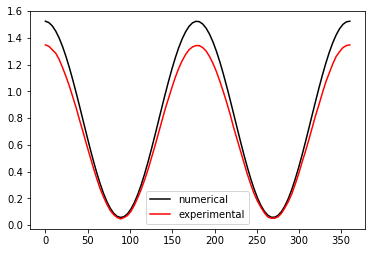

In [16]:
intensity_numerical=get_intensity_numerical_1(params_1_fin, angles_2, u0)
plt.figure()
plt.plot(angles_2/degrees, intensity_numerical,'k',label='numerical')
plt.plot(angles_2/degrees, intensities_2,'r', label='experimental')
plt.legend()

In [18]:
I_fitting=get_intensity_numerical_1(params_1_fin,angles_2, u0)
plot_experiment_residuals_1D(angles_2, intensities_2, I_fitting)

print(params_1_fin[0]/degrees)
residuals1=(I_fitting-intensities_2)
print("std_residuals 1={}, = {} %".format(sp.std(residuals1),
                                          sp.std(residuals1)/intensities_2.max()*100))

0.808412417456
std_residuals 1=0.0609337747533, = 4.52376902497 %


## Fitting to matrices - 2: completo
Aquí hacemos el ajuste al ángulo, y p0,p1 de los polarizadores

In [19]:
pol_dicts =get_polarimeter_parameters(kind='exp')
pol1,pol2,pol3, pol4 = pol_dicts
p0=pol1['p0']
p1=pol1['p1']

In [20]:
P1=polarizer_linear(p1=p1, p2=p0, theta=0)
print(P1)

[[ 0.47408831  0.45647711  0.          0.        ]
 [ 0.45647711  0.47408831  0.          0.        ]
 [ 0.          0.          0.12801708  0.        ]
 [ 0.          0.          0.          0.12801708]]


In [21]:
def get_intensity_numerical_all(par_fitting, angles, u0):
    """
    par_fitting es el ángulo del polarizador 4"""
    
    angle_4, p1, p0=par_fitting
    
    P1=polarizer_linear(p1=p1, p2=p0, theta=0)
    P4=polarizer_linear(p1=p1, p2=p0, theta=angle_4)
        
    intensity_numerical=sp.zeros_like(angles,dtype=float)
    for i, angle in enumerate(angles):
        P4_r =rotate_mueller(P4, angle)
        intensity_numerical[i]=intensity(P4_r*P1*u0)
    
    return intensity_numerical

In [22]:
errfunc3 = lambda par, x, u0, y: abs(get_intensity_numerical_all(par, x,u0) - y) 
# Distance to the target function

In [23]:
params_all_ini=[0*degrees, .9, 0.1]  #theta, p1, p0
params_all_fin, success = optimize.leastsq(errfunc3, params_all_ini, 
                                           args=(angles_2, u0, intensities_2))
print("p0={}, p1={}, angulo={}º".format(params_all_fin[2], params_all_fin[1], 
                                        params_all_fin[0]/degrees))

p0=0.128856857551, p1=0.935181526985, angulo=0.80363111679º


### Verificación
Aquí utilizamos el modelo numérico del polarímetro para verificar que se obtiene el resultado experimental

In [24]:
[amplitude, angle, phase], u0= get_light_parameters()
print(u0)

[[ 3.54305329]
 [-0.0246113 ]
 [ 0.01261461]
 [ 3.54294535]]


In [25]:
intensity_numerical=get_intensity_numerical_all(params_all_fin, angles_2, u0)
plot_experiment_residuals_1D(angles_2, intensities_2, intensity_numerical)

residuals2=(intensity_numerical-intensities_2)
print("std_residuals={}, = {} %".format(sp.std(residuals2),
                                        sp.std(residuals2)/intensities_2.max()*100))

std_residuals=0.00241842637946, = 0.179545783745 %


## Resultados

In [26]:
# Método 1
Imin=par1[0]-par1[1]
Imax=par1[0]+par1[1]
I0 = 3.1049
angle4_max=params_1_fin

if Imin>Imax:
    Imin,Imax=Imax,Imin

print("I0        = {:4.4} V".format(I0))
print("Imin      = {:4.4} V".format(Imin))
print("Imax      = {:4.4} V".format(Imax))
print("angle_max = {:4.5} º".format(angle4_max/degrees))

p0=((Imax+sp.sqrt(Imax**2-Imin**2))/I0)**(0.25)
p1=sp.sqrt(Imin/sp.sqrt(I0*(Imax+sp.sqrt(Imax**2-Imin**2))))

if p0>p1:
    p0,p1=p1,p0 
    

I0        = 3.105 V
Imin      = -1.243 V
Imax      = 1.346 V
angle_max = [ 0.8 º


### Comparación

In [27]:
# Metodo 1
print("Polarizer, Method 1 p0={}, p1={}, angulo={}º".format(p0, p1, params_1_fin[0]/degrees))

# Método 2
print("Polarizer, Method 2 p0={}, p1={}, angulo={}º".format(params_all_fin[2], params_all_fin[1], params_all_fin[0]/degrees))

# Metodo 1
print("std_residuals 1={}, = {} %".format(sp.std(residuals1),sp.std(residuals1)/intensities_2.max()*100))

# Metodo 2
print("std_residuals={}, = {} %".format(sp.std(residuals2),sp.std(residuals2)/intensities_2.max()*100))


Polarizer, Method 1 p0=0.719111320298j, p1=0.879877181581, angulo=0.808412417456º
Polarizer, Method 2 p0=0.128856857551, p1=0.935181526985, angulo=0.80363111679º
std_residuals 1=0.0609337747533, = 4.52376902497 %
std_residuals=0.00241842637946, = 0.179545783745 %


### Conclusión
Me fio más del segundo método